## Recurrent Neural Network 
- Dealing with sequential data (eg. time series, text, audio, image captioning)
- capture dynamics of sequences via reccurent connections, which can be though of as cycles in the network of nodes
- unrolled across time, the network looks like a feedforward network with multiple copies of the same network, each passing a message to a successor
- each can look at the previous hidden state and the current input to decide what to do next. hidden state is a summary of the past sequence of inputs
- 4 styles: one to sequence, sequence to one, sequence to sequence, encoder-decoder
- Major issues: vanishing and exploding gradients, long-term dependencies : ==> (LSTM(long short term memory), GRU(gated recurrent unit) to solve)

### Working with sequences
- sequence of ordered vectors
- sequence modeling: given collection of sequences, estimate probability mass function that tells us the likelihood of a sequence
- Autorregressive models: predict next element in sequence given previous elements
- Markov models: predict next element in sequence given fixed number of previous elements ($\tau$) ($P(x_{t+1}|x_t, x_{t-1}, ..., x_{t-\tau})$). $\tau$ is the order of the model
-  Markov condition, i.e., that the future is conditionally independent of the past, given the recent history. 
-  

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

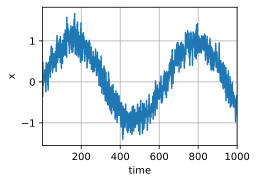

In [36]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2 # add some noise

data = Data()
d2l.plot(data.time, data.x, "time", "x", xlim=[1,1000])
        

In [37]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
    self.features = torch.stack(features, 1)
    self.labels = self.x[self.tau:].reshape((-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

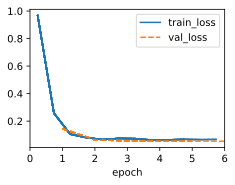

In [38]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=6)
trainer.fit(model, data)

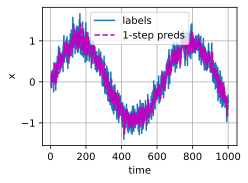

In [39]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], "time", "x", legend=["labels", "1-step preds"])


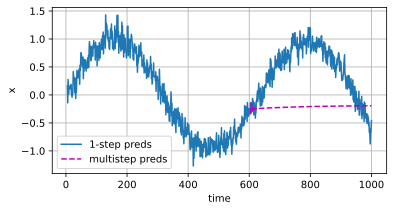

In [ ]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

## notice horrible performance.. as for each k step errors build up

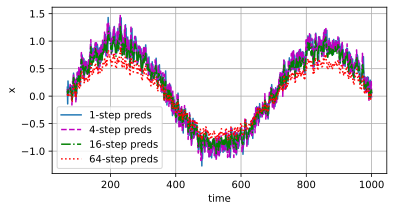

In [44]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))